## Visualize the CNN channels (pretrained and finetuned)

This code imports the network graph and weights after finetuning and uses the lucid4keras[1] wrapper to generate the visualizations. Results in interpretability_results/inceptionv3_finetuned. This code was also applied to visualize the channel activations of InceptionV3 pretrained on ImageNet. See the details below in the comments. 

In [2]:
#importing keras, tensorflow and configuring GPU device
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
configtf = tf.ConfigProto()
configtf.gpu_options.allow_growth = True
configtf.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=configtf))

#standard libraries
import numpy as np
import os
from PIL import Image
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import sys
import requests
from StringIO import StringIO

#visualization toolboxes
%matplotlib inline
import matplotlib.pyplot as plt
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
import lucid.optvis.param as param
from lucid.optvis.render import make_t_image, make_transform_f, make_optimizer
from lucid.misc.io import show, save
from lucid.misc.io.serialize_array import _normalize_array as normalize_array
from lucid.optvis.param.color import to_valid_rgb
from lucid.optvis.param.spatial import fft_image
from keras import activations
from lucid4keras import prepare_model
from lucid4keras.optimizers import *
#from lucid4keras import objectives as keras_objectives 


# keras specific
import keras.backend as K
from keras.layers import Lambda,Input
from keras.models import Model

#my own libraires
import keras_objectives
reload(keras_objectives)
from input_noise_generator import *
from visualizer import *

from lucid.misc.io.serialize_array import _normalize_array
import PIL.Image

/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
keras.backend.clear_session()
# Import your model here. 

# We use InceptionV3 and load the weigths 
# after finetuning on the histopathology task for 30 epochs 
model_finetuned = keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1)
model_finetuned.load_weights('../../camnet/inceptionv3_30epochs/tumor_classifier.h5')

# We remove the non-linear activations that would otherwise affect the quality of the 
# visualizations
model_finetuned =  prepare_model(model_finetuned,layer_name='mixed9')

'''NOTE: 
The same code can be used to visualize the channel activations of InceptionV3 
pretrained on ImageNet (before finetuning)

For instance, you can run:

model_finetuned = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1)
model_finetuned =  prepare_model(model_finetuned,layer_name='mixed9')


'''

('mixed9', <keras.layers.merge.Concatenate object at 0x7f854f62b090>, 'is a merge layer. will linearize connected relu containing layers')
('\tlinearizing layer:', 'activation_77')
('\tlinearizing layer:', 'activation_79')
('\tlinearizing layer:', 'activation_80')
('\tlinearizing layer:', 'activation_83')
('\tlinearizing layer:', 'activation_84')
('\tlinearizing layer:', 'activation_85')


"NOTE: \nThe same code can be used to visualize the channel activations of InceptionV3 \npretrained on ImageNet (before finetuning)\n\nFor instance, you can run:\n\nmodel_finetuned = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1)\nmodel_finetuned =  prepare_model(model_finetuned,layer_name='mixed9')\n\n\n"

In [9]:
os.mkdir('./interpretability_results/lucid_inceptionv3_finetuned_30epochs/')
os.mkdir('./interpretability_results/lucid_inceptionv3_finetuned_30epochs/mixed7c')

In [25]:
HOME_DIR='./interpretability_results/inceptionv3_finetuned/mixed7c/'

In [80]:
model_finetuned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
def save_img(object, handle, **kwargs):
    """Save numpy array as image file on CNS."""

    if isinstance(object, np.ndarray):
        normalized = _normalize_array(object)
        object = PIL.Image.fromarray(normalized)

    if isinstance(object, PIL.Image.Image):
        object.save(handle, **kwargs)  # will infer format from handle's url ext.
    else:
        raise ValueError("Can only save_img for numpy arrays or PIL.Images!")

In my own keras_render_vis
in here
(512, 13.911373)



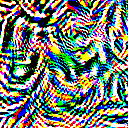

In my own keras_render_vis
in here
(1, array([-0.81177074, -0.8117707 ], dtype=float32))



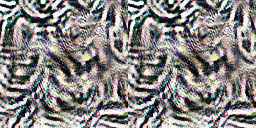

(32, array([-0.14654234, -0.1463525 ], dtype=float32))



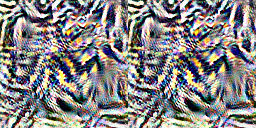

(1024, array([25.340567, 25.339275], dtype=float32))



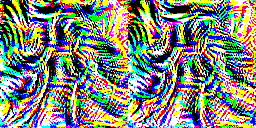

In my own keras_render_vis
in here
(1, array([0.1618718 , 0.16187175], dtype=float32))



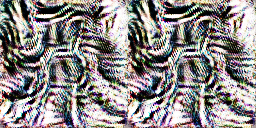

(512, array([-0.1363264 , -0.13628525], dtype=float32))



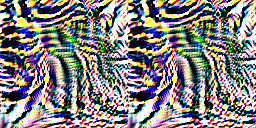

(2048, array([11.206432, 11.205913], dtype=float32))



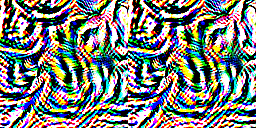

In [26]:
standard_transforms = [
    transform.pad(12, mode="constant", constant_value=.5),   
    transform.jitter(8),
    transform.random_scale([1 + (i - 5) / 50. for i in range(11)]),
    transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
    transform.jitter(4),
]

light_transforms = [
    transform.jitter(8),
    transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
    transform.jitter(2)
]
heavy_transforms = [
    transform.jitter(16),
    transform.random_scale([1 + (i - 5) / 150. for i in range(11)]),
    transform.random_rotate(list(range(-10, 11)) + 2 * [0]),
    transform.jitter(4),
]

all_losses=[]

for channel_no in range(140,141,1):
    
    ## step 1. obj is to optimize just the channel activations
    obj  = keras_objectives.channel(channel_no)

    # input image is perlini noise
    noise_image = get_noise_image(128)
    noise_image -= np.mean(noise_image)
    noise_image/=np.std(noise_image)
    init_val=np.asarray(np.expand_dims(noise_image,axis=0), dtype=np.float32)
    param_f = lambda: image(128, fft=True, decorrelate=True, init_val=init_val)
    
    images, loss = keras_render_vis(model_finetuned, 
                                    obj, 
                                    param_f, 
                                    thresholds=[512], 
                                    transforms=standard_transforms,
                                    learning_rate=0.1
                                   )
    
    all_losses.append(loss)
    # saving the intermediate images too
    save_input_url = HOME_DIR + \
                    'channel{}_step1_{}'.format(channel_no, loss[-1])
    save_img(images[0], save_input_url+'.png')
    np.save(save_input_url+'.npy', images[0])
    
    
    #continue
    ## step 2. obj is to max the channel activations AND reduce the total variation
    # obtaining more realistic-looking images
    
    obj  = keras_objectives.channel(channel_no) + \
            keras_objectives.total_variation(penalty=0.025) 
        
    # starting the optimization from where it was left at step1
    param_f = lambda: image(128, 
                            fft=True, 
                            decorrelate=True, 
                            init_val=np.asarray(images[0], dtype=np.float32))
    
    # decreasing the learning rate of a factor of 1e-1
    # simplifying the image by removing any transforms and robustness
    images, loss = keras_render_vis(model_finetuned, 
                                    obj, 
                                    param_f, 
                                    thresholds=[1,32,1024],
                                    transforms=light_transforms,
                                    learning_rate=0.1
                                   )
    loss = [l[1] for l in loss[2:]]
    all_losses.append(loss)
    
    # saving the intermediate images too
    save_input_url = HOME_DIR+ \
                    'channel{}_step2_{}'.format(channel_no, loss[-1])
   
    np.save(save_input_url+'.npy', images[-1,-1])
    save_img(images[-1,-1], save_input_url+'.png')
    
    # starting the optimization from where it was left at step2
    obj  = keras_objectives.channel(channel_no) + \
            keras_objectives.total_variation(penalty=0.0025)
    param_f = lambda: image(128,
                            fft=True, 
                            decorrelate=True, 
                            init_val=np.asarray(np.expand_dims(images[1,-1], axis=0), dtype=np.float32))
    # decreasing learning rate
    images, loss = keras_render_vis(model_finetuned, 
                                    obj, 
                                    param_f, 
                                    thresholds=[1, 512, 2048],
                                    transforms=standard_transforms,
                                    learning_rate=0.01)
    
    loss = [l[1] for l in loss[2:]]
    all_losses.append(loss)
    save_input_url = HOME_DIR+ \
                    'channel{}_step3_{}'.format(channel_no, loss[-1])
   
    np.save(save_input_url+'.npy', images[-1,-1])
    save_img(images[-1,-1], save_input_url+'.png')


In my own keras_render_vis
in here
(1, array([-0.552824, -0.552824], dtype=float32))



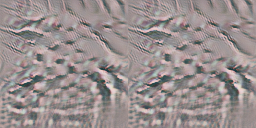

(10, array([-0.62692976, -0.62693024], dtype=float32))



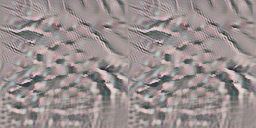

(512, array([1.1707382, 1.1710719], dtype=float32))



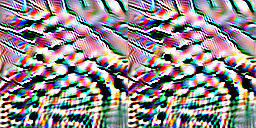

(2048, array([5.9721956, 5.972271 ], dtype=float32))



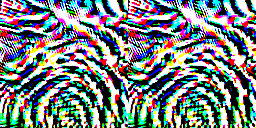

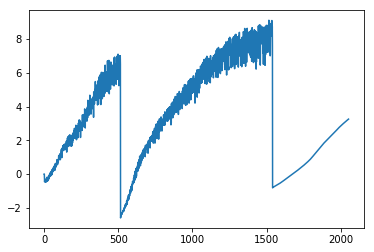

In [45]:
plt.plot(all_losses[0]+all_losses[1]+all_losses[2])

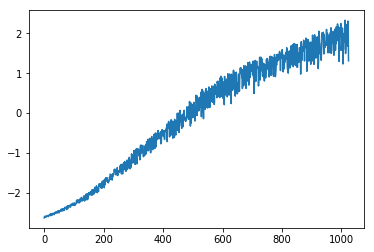

In [37]:
plt.plot(all_losses[1])

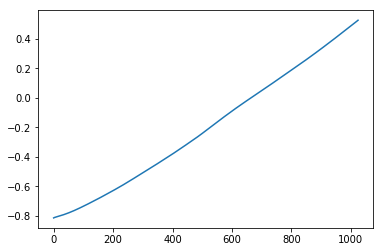

In [38]:
plt.plot(all_losses[2])

In [8]:
np.save(save_input_url+'.npy', images[-1,-1])
save_img(images[-1,-1], save_input_url+'.png')